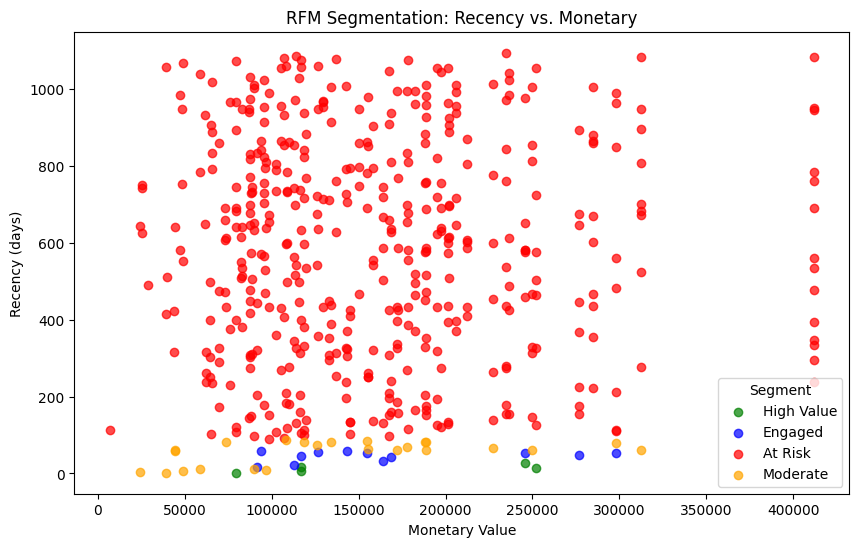

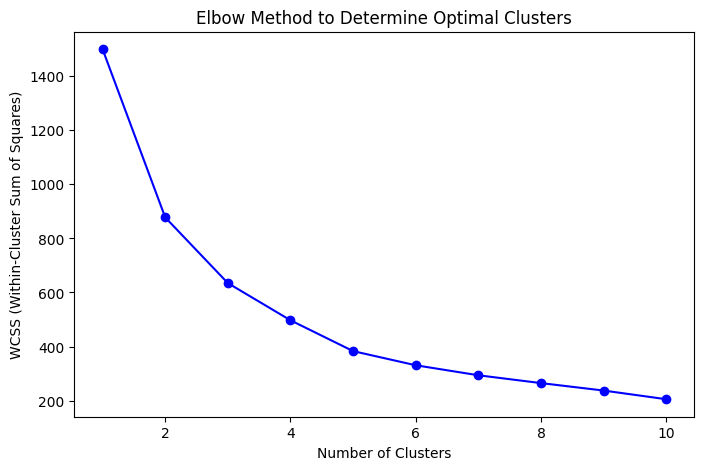

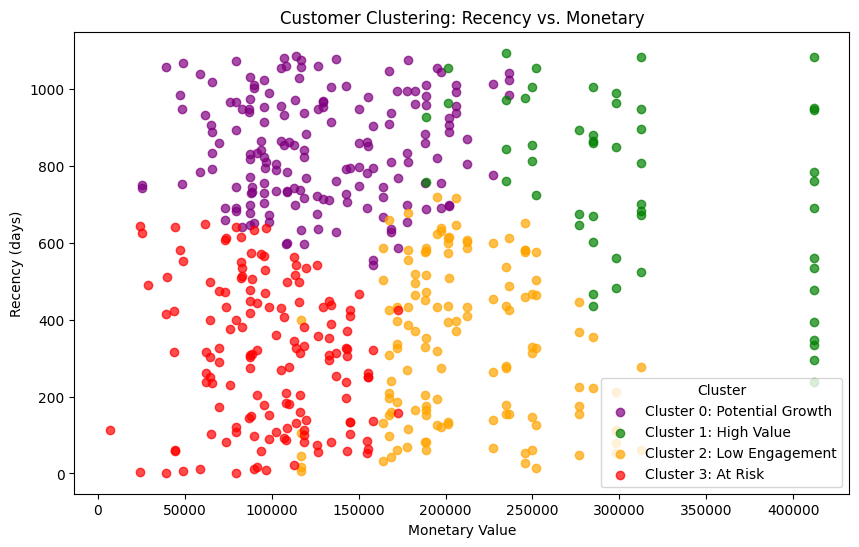

In [3]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load dataset
data = pd.read_csv('/content/sample_loans.csv')

# Create RFM metrics
data['Recency'] = (pd.Timestamp.now() - pd.to_datetime(data['Last Application Date'])).dt.days
data['Frequency'] = data.groupby('Customer ID')['Loan ID'].transform('count')
data['Monetary'] = data.groupby('Customer ID')['Loan Amount'].transform('sum')

# Define segmentation logic
def classify_rfm(row):
    if row['Recency'] < 30 and row['Frequency'] > 5 and row['Monetary'] > 5000:
        return 'High Value'
    elif row['Recency'] < 60 and row['Frequency'] > 3:
        return 'Engaged'
    elif row['Recency'] >= 90:
        return 'At Risk'
    else:
        return 'Moderate'

data['Segment'] = data.apply(classify_rfm, axis=1)

# Visualization: RFM Segments Scatter Plot
plt.figure(figsize=(10, 6))
colors = {
    'High Value': 'green',
    'Engaged': 'blue',
    'At Risk': 'red',
    'Moderate': 'orange'
}
for segment, color in colors.items():
    segment_data = data[data['Segment'] == segment]
    plt.scatter(
        segment_data['Monetary'],
        segment_data['Recency'],
        c=color,
        label=segment,
        alpha=0.7
    )

plt.title('RFM Segmentation: Recency vs. Monetary')
plt.xlabel('Monetary Value')
plt.ylabel('Recency (days)')
plt.legend(title='Segment')
plt.show()

# Scale features for clustering
scaler = StandardScaler()
features = ['Recency', 'Frequency', 'Monetary']
data_scaled = scaler.fit_transform(data[features])

# Elbow Method to Find Optimal K
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='blue')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method to Determine Optimal Clusters')
plt.show()

# Train the K-Means Model
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['Cluster'] = kmeans.fit_predict(data_scaled)

# Scatter Plot: Clusters Visualization
plt.figure(figsize=(10, 6))
cluster_colors = ['purple', 'green', 'orange', 'red']
cluster_labels = [
    'Cluster 0: Potential Growth',
    'Cluster 1: High Value',
    'Cluster 2: Low Engagement',
    'Cluster 3: At Risk'
]

for cluster_id in range(optimal_k):
    cluster_data = data[data['Cluster'] == cluster_id]
    plt.scatter(
        cluster_data['Monetary'],
        cluster_data['Recency'],
        c=cluster_colors[cluster_id],
        label=cluster_labels[cluster_id],
        alpha=0.7
    )

plt.title('Customer Clustering: Recency vs. Monetary')
plt.xlabel('Monetary Value')
plt.ylabel('Recency (days)')
plt.legend(title='Cluster')
plt.show()
